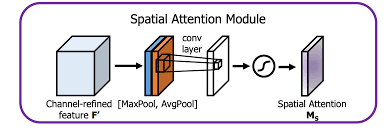

In [26]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size = 3, padding = 1):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding, bias = False)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # 채널을 1로 압축
        max_out, _ = torch.max(x, dim=1, keepdim=True) # 채널을 1로 압축
        x = torch.cat([avg_out,max_out], dim=1)
        x = self.conv1(x)
        x = self.sig(x)
        return x  

In [25]:
# test
input_tensor = torch.randn(1, 64, 32, 32)  # (batch_size=1, channels=64, height=32, width=32)
sa = SpatialAttention()
output_tensor = sa(input_tensor)
print(output_tensor.shape)  

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 30, 30])
